In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

from utils import data4pred, pred4pred

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
df = pd.read_csv("../Assets/Data/jkse.csv", parse_dates=["Date"], index_col="Date")
df = df[~df.price.isna()]
df.price = df.price.transform(lambda x: (x-x.mean())/x.std())
df

,price
Date,
2009-01-05,-2.455690
2009-01-06,-2.457178
2009-01-07,-2.468795
2009-01-08,-2.484328
2009-01-09,-2.472759
...,...
2018-12-20,1.434669
2018-12-21,1.447652
2018-12-26,1.418130


In [4]:
config = set_config({
    "input_size": 1,
    "seq_len": 7,
    "batch_size": 32,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0.1,
    "bidirectional": True,
    "cell_type": "lstm"
})
predict_column = "price"
lr = 0.01

In [5]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)

train_set = TimeSeriesDataset(ts_train, predict_column, config.seq_len)
trainloader = DataLoader(train_set, batch_size=config.batch_size)

test_set = TimeSeriesDataset(ts_test, predict_column, config.seq_len)
testloader = DataLoader(test_set, batch_size=config.batch_size)

(N, S, F): (277, 7, 1)
Note: last 0 data excluded

(N, S, F): (69, 7, 1)
Note: last 2 data excluded



In [6]:
class RNN(nn.Module):
    def __init__(self, cell_type, input_size, output_size, hidden_size, num_layers, dropout, bidirectional):
        super().__init__()
        
        if cell_type == "rnn":
            rnn_block = nn.RNN
        elif cell_type == "lstm":
            rnn_block = nn.LSTM
        elif cell_type == "gru":
            rnn_block = nn.GRU
        
        self.rnn = rnn_block(input_size, hidden_size, num_layers, dropout=dropout, bidirectional=bidirectional)
        
        if bidirectional:
            hidden_size = 2*hidden_size
            
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):        
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [7]:
model = RNN(config.cell_type, config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout, config.bidirectional).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=lr)
callback = Callback(model, config, outdir=f'model/jkse/')

In [9]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    return cost / len(dataset)

Test: 100%|██████████| 3/3 [00:00<00:00, 37.00it/s]



Epoch     1
Train_cost  = 0.8366 | Test_cost  = 0.6794 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 60.03it/s]



Epoch     2
Train_cost  = 0.7838 | Test_cost  = 0.1360 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.73it/s]



Epoch     3
Train_cost  = 0.6889 | Test_cost  = 0.9408 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1360


Test: 100%|██████████| 3/3 [00:00<00:00, 66.68it/s]



Epoch     4
Train_cost  = 0.2292 | Test_cost  = 1.5356 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1360


Test: 100%|██████████| 3/3 [00:00<00:00, 58.86it/s]



Epoch     5
Train_cost  = 0.5711 | Test_cost  = 0.9050 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1360


Test: 100%|██████████| 3/3 [00:00<00:00, 58.85it/s]



Epoch     6
Train_cost  = 0.1521 | Test_cost  = 0.1252 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 46.90it/s]



Epoch     7
Train_cost  = 0.1651 | Test_cost  = 0.3511 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1252


Test: 100%|██████████| 3/3 [00:00<00:00, 51.76it/s]



Epoch     8
Train_cost  = 0.2412 | Test_cost  = 0.1092 | 


Test: 100%|██████████| 3/3 [00:00<00:00,  6.68it/s]



Epoch     9
Train_cost  = 0.1099 | Test_cost  = 0.2106 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1092


Test: 100%|██████████| 3/3 [00:00<00:00, 11.77it/s]



Epoch    10
Train_cost  = 0.0801 | Test_cost  = 0.3850 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1092


Test: 100%|██████████| 3/3 [00:00<00:00, 46.18it/s]



Epoch    11
Train_cost  = 0.0472 | Test_cost  = 0.2029 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1092


Test: 100%|██████████| 3/3 [00:00<00:00, 46.18it/s]



Epoch    12
Train_cost  = 0.0184 | Test_cost  = 0.1852 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1092


Test: 100%|██████████| 3/3 [00:00<00:00, 58.86it/s]



Epoch    13
Train_cost  = 0.0110 | Test_cost  = 0.0801 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.73it/s]



Epoch    14
Train_cost  = 0.0095 | Test_cost  = 0.0613 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.58it/s]



Epoch    15
Train_cost  = 0.0093 | Test_cost  = 0.0595 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 27.54it/s]



Epoch    16
Train_cost  = 0.0113 | Test_cost  = 0.0622 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0595


Test: 100%|██████████| 3/3 [00:00<00:00, 25.44it/s]



Epoch    17
Train_cost  = 0.0167 | Test_cost  = 0.0975 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0595


Test: 100%|██████████| 3/3 [00:00<00:00, 48.42it/s]



Epoch    18
Train_cost  = 0.0353 | Test_cost  = 0.0827 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0595


Test: 100%|██████████| 3/3 [00:00<00:00, 54.57it/s]



Epoch    19
Train_cost  = 0.0712 | Test_cost  = 0.2845 | 
==> EarlyStop patience =  4 | Best test_cost: 0.0595


Test: 100%|██████████| 3/3 [00:00<00:00, 61.26it/s]



Epoch    20
Train_cost  = 0.1174 | Test_cost  = 0.0668 | 


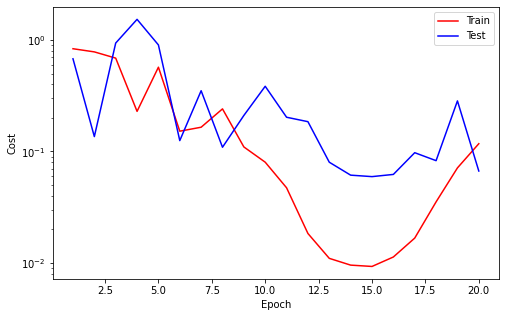

==> EarlyStop patience =  5 | Best test_cost: 0.0595
==> Execute Early Stopping at epoch: 20 | Best test_cost: 0.0595
==> Best model is saved at model/jkse/


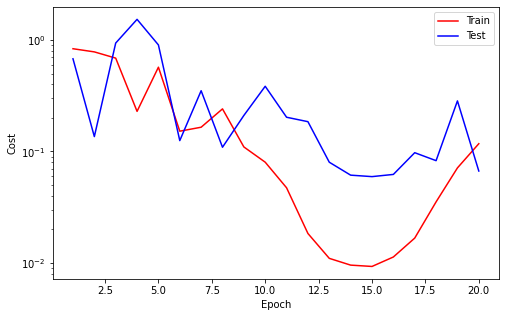

In [10]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

In [11]:
train_forecast_set = TimeSeriesDataset(ts_train, predict_column, 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, predict_column, 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (1939, 1, 1)
Note: last 0 data excluded

(N, S, F): (485, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Train')

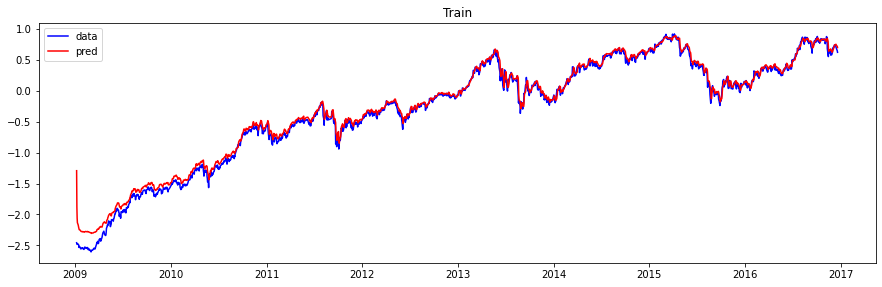

In [19]:
plt.figure(figsize=(15, 15))
plt.subplot(311)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

Text(0.5, 1.0, 'Test')

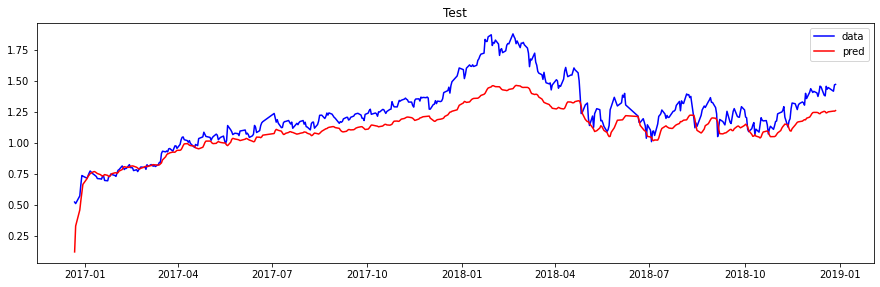

In [17]:
plt.figure(figsize=(15, 15))
plt.subplot(312)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'Test')

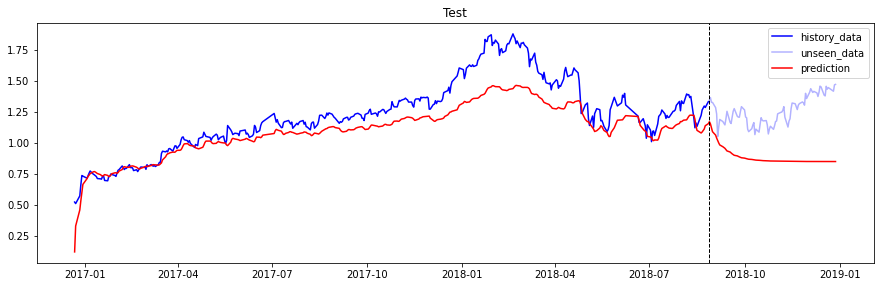

In [18]:
plt.figure(figsize=(15, 15))
plt.subplot(313)
pred4pred(model, test_forecast_set, testforecastloader, device, n_prior=400, n_forecast=100)
plt.title("Test")